<a href="https://colab.research.google.com/github/uanak/DXbootcamp/blob/main/bootCamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

各種インストール
mecab(要素解析）,pytorch,kmeans（クラスタ）

In [ ]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.7
!pip install -U torch torchvision
!pip install kmeans-pytorch

import MeCab
import numpy as np
import torch
import torch.nn as nn
from gensim import corpora, matutils
from google.colab import drive
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader
from torch import optim
import matplotlib.pyplot as plt

# from kmeans_pytorch import kmeans
device = torch.device('cuda:0')

In [103]:
drive.mount('/content/drive')
dataframe = pd.read_csv('drive/My Drive/dxboot/test2.csv')
dataframe = dataframe.sample(frac=1)
lenFrame = len(dataframe)

category = dataframe['category'].values.tolist()
categoryTest = category[:lenFrame//11]
category=category[lenFrame//11:]

topic = dataframe['topic'].values.tolist()
topicTest = topic[:lenFrame//11]
topic = topic[lenFrame//11:]

categoryTensor=torch.unsqueeze(torch.tensor(category),1)
categoryTestTensor=torch.unsqueeze(torch.tensor(categoryTest),1)

# dataloaderを使いたかったが、文字列の関係でテンソルがうまく作れず断念

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
mecab = MeCab.Tagger("-Ochasen")
mecab.parse('')

def bunkai(contents):
    ret = []
    for  content in contents:
        tmp = bunkaiChi(content)
        if not tmp:
          print("答えと入力がバラバラになってしまうぞ")
          continue
        else :
          ret.append(tmp)
    return ret
def bunkaiChi(content):
  return [token for token in doMecab(content)]

def doMecab(text):
  nodes = mecab.parseToNode(text)
  while nodes:
    if nodes.feature.split(',')[0] == '名詞':
      yield nodes.surface.lower()
      # 名詞なしの文章のため
    elif nodes.feature.split(',')[0] == '動詞':
      yield nodes.surface.lower()
    nodes = nodes.next

# 分解して動詞と名詞だけをリスト化
wordlists = bunkai(topic)
wordlistsTest = bunkai(topicTest)
# 辞書を作成（学習用のデータだけで）
jisho = corpora.Dictionary(wordlists)

In [111]:
# ゆきながせんせいのソースをほとんどまるっと利用。。
class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn = nn.RNN(  
        # self.rnn = nn.LSTM(  
            input_size=2,  
            hidden_size=128, 
            batch_first=True, 
        )
        self.fc = nn.Linear(128, 5)  

    def forward(self, input):
        y_rnn, h = self.rnn(input, None)  
        y = self.fc(y_rnn[:, -1, :]) 
        return y

rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(2, 256, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
)


In [112]:
# 分類なので、交差エントロピー誤差
lossFn = nn.CrossEntropyLoss()
learning_rate = 0.000000005

optimizer = optim.SGD(rnn.parameters(), lr=learning_rate)
# optimizer = optim.Adam(rnn.parameters(), lr=learning_rate)

loss_train = 0
record_loss_train = []
record_loss_test = []

# オンライン学習
rnn.train() 
for i, word in enumerate(wordlists):
  data = torch.tensor(jisho.doc2bow(word))
  data = torch.unsqueeze(data, 0)
  rnn.zero_grad()
  input_data = torch.tensor(data, dtype=torch.float)
  output = rnn(input_data)
  answer = categoryTensor[i]
  loss = lossFn(output, answer)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  loss_train += loss.item()
  loss_train /= i+1
  record_loss_train.append(loss_train)
  if i%500==0:
    print("Epoch:", i, "Loss_Train:", loss_train)
print("Epoch:", i, "Loss_Train:", loss_train)

rnn.eval()  # 評価モード
loss_test = 0
correct = 0
for i, word in enumerate(wordlistsTest):
  data = torch.tensor(jisho.doc2bow(word,allow_update=True))
  data = torch.tensor(torch.unsqueeze(data, 0), dtype=torch.float)
  y = rnn(data)
  t = categoryTestTensor[i]
  loss = lossFn(y, t)
  loss_test += loss.item()
  loss_test /= i+1
  if y.argmax(1)==t:
    correct += 1
  if i%100==0:
    print("Epoch:", i, "Loss_Train:", loss_test)

record_loss_test.append(loss_test)
print( "Loss_Train:", loss_train, "Loss_Test:", loss_test)
print("正解率:", str(correct/len(wordlistsTest)*100) + "%")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch: 0 Loss_Train: 1.5715209245681763
Epoch: 500 Loss_Train: 0.0034666184675858545
Epoch: 1000 Loss_Train: 0.001415022463674866
Epoch: 1500 Loss_Train: 0.0012374330080726817
Epoch: 2000 Loss_Train: 0.0007065215085917685
Epoch: 2500 Loss_Train: 0.0006932703240554199
Epoch: 3000 Loss_Train: 0.0006377208155522941
Epoch: 3500 Loss_Train: 0.0005484430208228747
Epoch: 3884 Loss_Train: 0.000332069424019336
Epoch: 0 Loss_Train: 1.9200783967971802
Epoch: 100 Loss_Train: 0.01827489517161811
Epoch: 200 Loss_Train: 0.007056404579875747
Epoch: 300 Loss_Train: 0.004311867734162326


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss_Train: 0.000332069424019336 Loss_Test: 0.003338062160186176
正解率: 18.04123711340206%


In [107]:
print(total)
print(correct)
print("正解率:", str(correct/total*100) + "%")
# 3:1のときは正解率が19%程度
# 7:1のときは21、10:1のときは24%
# LSTMにしてみても大して変わらず

387
62
正解率: 16.020671834625322%


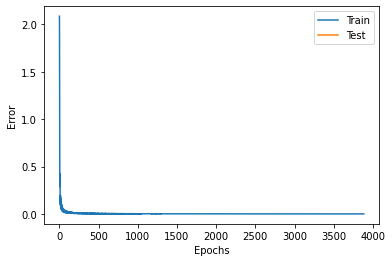

In [108]:

plt.plot(range(len(record_loss_train)), record_loss_train, label="Train")
plt.plot(range(len(record_loss_test)), record_loss_test, label="Test")
plt.legend()

plt.xlabel("Epochs")
plt.ylabel("Error")
plt.show()